In [1]:
import os
import numpy as np
import PIL
import torch
from PIL import Image

from transformers import OwlViTModel, OwlViTConfig, OwlViTForObjectDetection
from transformers.image_utils import ImageFeatureExtractionMixin
mixin = ImageFeatureExtractionMixin()
from transformers import CLIPTokenizer, CLIPFeatureExtractor
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32", pad_token='!')

In [2]:
config = OwlViTConfig()
model = OwlViTForObjectDetection.from_pretrained("owlvit_base")

IMAGE_MEAN = np.array([0.48145466, 0.4578275, 0.40821073])
IMAGE_STD = np.array([0.26862954, 0.26130258, 0.27577711])
feat_ext = CLIPFeatureExtractor(size=768, crop_size=768, image_mean=IMAGE_MEAN, image_std=IMAGE_STD)

## Prepare image and text queries

In [3]:
image = Image.open("astronaut.png")
image = mixin.resize(image, 768)
image = np.asarray(image) / 255.0

image = np.swapaxes(image, 1,2)
image = np.swapaxes(image, 0,1)
image = feat_ext(image, return_tensors="pt")["pixel_values"].to(torch.float32)

# Tokenize queries
text_queries = ["human face", "rocket", "nasa badge", "star-spangled banner"]
tokenized_queries = tokenizer(text_queries, max_length=16, padding="max_length", return_tensors="pt")
input_ids = tokenized_queries["input_ids"]
attention_mask = tokenized_queries["attention_mask"]

## Get predictions

In [7]:
outputs = model(pixel_values=image, input_ids=input_ids, attention_mask=attention_mask)

## Draw predictions on image

In [8]:
from matplotlib import pyplot as plt
from transformers.image_utils import ImageFeatureExtractionMixin
mixin = ImageFeatureExtractionMixin()


score_threshold = 0.1
pred_logits = outputs["logits"].squeeze(0).detach().numpy()
logits = pred_logits[..., :len(text_queries)]  # Remove padding.
scores = 1 / (1 + np.exp(-1 * np.max(logits, axis=-1)))

labels = np.argmax(pred_logits, axis=-1)
boxes = outputs["pred_boxes"].squeeze(0).detach().numpy()

In [9]:
# Load example image
IMAGE_MEAN = np.array([0.48145466, 0.4578275, 0.40821073])
IMAGE_STD = np.array([0.26862954, 0.26130258, 0.27577711])

image = Image.open("astronaut.png")
image = mixin.resize(image, 768)
input_image = np.asarray(image).astype(np.float32) / 255.0

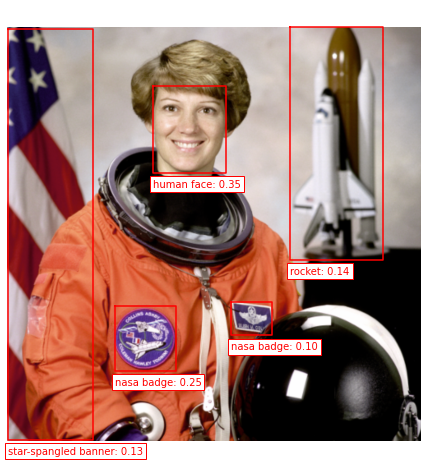

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(input_image, extent=(0, 1, 1, 0))
ax.set_axis_off()

for score, box, label in zip(scores, boxes, labels):
  if score < score_threshold:
    continue

  cx, cy, w, h = box
  ax.plot([cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
          [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2], "r")
  ax.text(
      cx - w / 2,
      cy + h / 2 + 0.015,
      f'{text_queries[label]}: {score:1.2f}',
      ha="left",
      va="top",
      color="red",
      bbox={
          "facecolor": "white",
          "edgecolor": "red",
          "boxstyle": "square,pad=.3"
      })